# LSTM

Learn how to make a multivariate forecast a LSTM network on BTC price data. The data is on minute intervals. 

This network is trained on two inputs: 
1) average high and low price for every minute
2) the volume to produce the forecast. 

<p>*Please Note* this dataset is extremely small. As a result, it doesn't produce a great forecast. A small dataset is used in order to reduce training time and merely demonstrate the steps that are required for learning purposes.</p><p> Code is largely borrowed from Renu Khandelwal's Tutorial <a href="https://medium.com/datadriveninvestor/multivariate-time-series-using-rnn-with-keras-7f78f4488679"> Multivariate Time Series using RNN with Keras </a>. </p> <p>Pictures are taken from a <a href="https://github.com/Arturus/kaggle-web-traffic/blob/master/how_it_works.mdtutorial"> tutorial on RNNs for time series forecasting </a> by Artur Suilin.</p> <p> Quotes are from <a href="https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Intro.ipynb">TimeSeries_Seq2Seq</a> by Joseph Eddy. Please take a look at their work </p>

## Step One:
Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
stock_data = pd.read_csv("Data/BTC_sm_nc.csv")

In [2]:
stock_data.head()

,time,close,high,low,open,volume
0,1483228740000000000,968.29,968.29,968.29,968.29,0
1,1483228800000000000,968.70,968.76,968.49,968.29,12993
2,1483228860000000000,968.43,968.70,967.20,968.70,73800
3,1483228920000000000,967.21,968.00,967.21,968.43,3500
4,1483228980000000000,966.97,967.21,966.74,967.21,15969


In [4]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
time      100 non-null int64
close     100 non-null float64
high      100 non-null float64
low       100 non-null float64
open      100 non-null float64
volume    100 non-null int64
dtypes: float64(4), int64(2)
memory usage: 4.8 KB


We will take the average of the low and high of the Google stock for the day and volume of the stocks traded for the day to predict the stock prices.

In [5]:
import math
stock_data["average"] = (stock_data["high"] + stock_data["low"])/2
stock_data.head()

,time,close,high,low,open,volume,average
0,1483228740000000000,968.29,968.29,968.29,968.29,0,968.290
1,1483228800000000000,968.70,968.76,968.49,968.29,12993,968.625
2,1483228860000000000,968.43,968.70,967.20,968.70,73800,967.950
3,1483228920000000000,967.21,968.00,967.21,968.43,3500,967.605
4,1483228980000000000,966.97,967.21,966.74,967.21,15969,966.975


Taking the volume and average stock price as our input features and store it in input_data

In [6]:
input_feature= stock_data.iloc[:,[2,6]].values
input_data = input_feature
input_data[0:2]

array([[968.29 , 968.29 ],
       [968.76 , 968.625]])

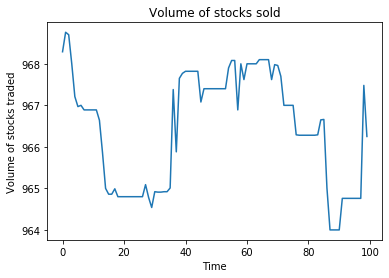

In [7]:
plt.plot(input_feature[:,0])
plt.title("Volume of stocks sold")
plt.xlabel("Time")
plt.ylabel("Volume of stocks traded")
plt.show()

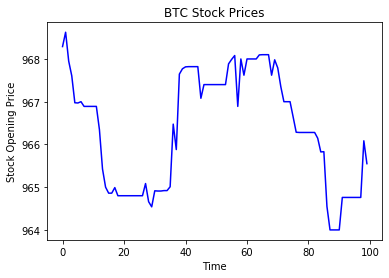

In [8]:
plt.plot(input_feature[:,1], color='blue')
plt.title("BTC Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Opening Price")
plt.show()

Normalizing the input data using MinMaxScaler so that all the input features are on the scale from 0 to 1. For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum. MinMaxScaler preserves the shape of the original distribution.

The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.Data Normalization is necessary for Machine Learning problems where the features have different ranges.

In [9]:
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_feature[:,:])

"We have to know how to appropriately partition the time series into encoding and decoding (prediction) intervals for the purposes of training and validation.

There are two ways to split timeseries into training and validation datasets:

Walk-forward split. This is not actually a split: we train on full dataset and validate on full dataset, using different timeframes. Timeframe for validation is shifted forward by one prediction interval relative to timeframe for training.
Side-by-side split. This is traditional split model for mainstream machine learning. Dataset splits into independent parts, one part used strictly for training and another part used strictly for validation.

We'll use a style of walk-forward validation, where our validation set spans the same time-range as our training set, but shifted forward in time (in this case by 10 minutes). This way, we simulate how our model will perform on unseen data that comes in the future."

![split validation](images/ArturSuilin_validation.png)

We loop through all the samples and for each day we go back 10 minutes in the past and add the volume of the stocks traded an average stock price.

In [10]:
lookback= 10

test_size=int(.3 * len(stock_data))
X=[]
y=[]
for i in range(len(stock_data)-lookback-1):
    t=[]
    for j in range(0,lookback):
        
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,1])

In [11]:
print("test_size")
print(test_size)
print("length of stock_data")
print(len(stock_data))
print("length of X")
print(len(X))
print("first 5 points of y")
print(y[0:5])
print("points 10-15 of input_data")
print(input_data[10:15,1])

test_size
30
length of stock_data
100
length of X
89
first 5 points of y
[0.6248648648648611, 0.6248648648648611, 0.5070270270270214, 0.30810810810808675, 0.21621621621622467]
points 10-15 of input_data
[0.62486486 0.62486486 0.50702703 0.30810811 0.21621622]


In [14]:
X, y= np.array(X), np.array(y)
X_test = X[:test_size+lookback]
X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
print(X.shape)
print(X_test.shape)
print(X[1])

(89, 10, 2)
(40, 10, 2)
[[1.         1.        ]
 [0.98739496 0.85405405]
 [0.84033613 0.77945946]
 [0.67436975 0.64324324]
 [0.62394958 0.64216216]
 [0.6302521  0.64864865]
 [0.60714286 0.62486486]
 [0.60714286 0.62486486]
 [0.60714286 0.62486486]
 [0.60714286 0.62486486]]


In [13]:
from keras import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [14]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 30)            3960      
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [16]:
model.fit(X, y, epochs=200, batch_size=10)



Epoch 1/200
89/89 [==============================] - 1s 12ms/step - loss: 0.2024
Epoch 2/200
89/89 [==============================] - 0s 1ms/step - loss: 0.0583
Epoch 3/200
89/89 [==============================] - 0s 2ms/step - loss: 0.0593
Epoch 4/200
89/89 [==============================] - 0s 1ms/step - loss: 0.0506
Epoch 5/200
89/89 [==============================] - 0s 1ms/step - loss: 0.0476
Epoch 6/200
89/89 [==============================] - 0s 1ms/step - loss: 0.0474
Epoch 7/200
89/89 [==============================] - 0s 1ms/step - loss: 0.0455
Epoch 8/200
89/89 [==============================] - 0s 1ms/step - loss: 0.0453
Epoch 9/200
89/89 [==============================] - 0s 1ms/step - loss: 0.0443
Epoch 10/200
89/89 [==============================] - 0s 1ms/step - loss: 0.0451
Epoch 11/200
89/89 [==============================] - 0s 1ms/step - loss: 0.0432
Epoch 12/200
89/89 [==============================] - 0s 1ms/step - loss: 0.0413
Epoch 13/200
89/89 [===============

89/89 [==============================] - 0s 1ms/step - loss: 0.0061
Epoch 200/200
89/89 [==============================] - 0s 1ms/step - loss: 0.0060


In [17]:
predicted_value= model.predict(X_test)


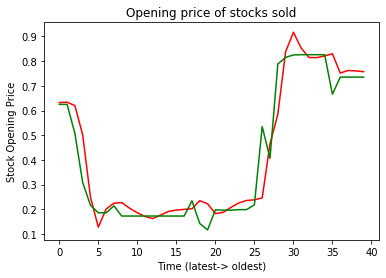

In [18]:
plt.plot(predicted_value, color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green')
plt.title("Opening price of stocks sold")
plt.xlabel("Time)")
plt.ylabel("Stock Opening Price")
plt.show()